In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Input, Activation, Dropout, BatchNormalization, LSTM, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam ,RMSprop
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from tensorflow.keras.regularizers import l2, l1

import yfinance as yf
import statsmodels as sms
import statsmodels.api as sm

pd.set_option('display.max_rows',60000)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',200)
pd.options.display.float_format = '{:,.10f}'.format
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Custom RMSE function
def rmse_numpy(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE).
    :param y_true: Ground truth values (actual).
    :param y_pred: Predicted values (forecast).
    :return: RMSE value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [3]:
v1 = pd.read_csv('outputs/my_data_view_1_0307.csv')

In [4]:
v1.head()

,name,mape,rmse,mae,real_price,last_actual_date,cum_return_40d,return_price_40d,one_day_fwd_return,one_day_fwd_price
0,PGR,479.8622127697,0.0214238257,0.0170248854,250.5377349854,2024-10-04,1.1968935389,299.8669962642,1.0003280531,250.6199246642
1,UNH,500.7424435648,0.0312661417,0.0247043192,588.9411621094,2024-10-04,1.0661103610,627.8762749668,1.0049833788,591.8760789880
2,LLY,"1,964.1625537598",0.0309973732,0.0242067013,885.6931152344,2024-10-04,0.9553034864,846.1057208963,0.9790445609,867.1330271168
3,IBM,414.1061448292,0.0201612624,0.0151127237,222.7488098145,2024-10-04,1.2149206423,270.6221270928,1.0017344231,223.1351504996
4,GS,958.8584889684,0.0264154986,0.0195086668,492.7190551758,2024-10-04,1.2583960237,620.0356998279,0.9911069425,488.3372762974


In [5]:
df = pd.read_csv('outputs/time_forecasted_0307.csv')

In [6]:
210.1347351074	+ (210.1347351074	* ( -0.0058269208))

208.9102966486002

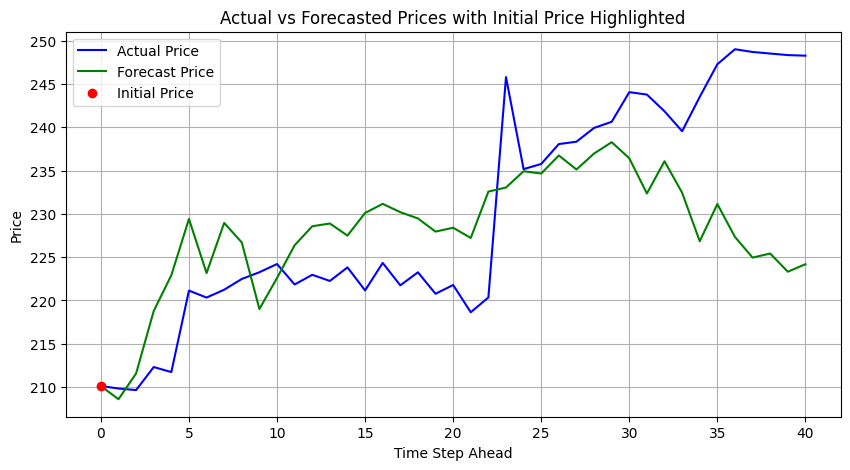

In [7]:
xx = df[df['stock']=='JPM'] #normal tft prediction 
actual_returns = np.array(xx['Test Series'])
forecast_returns = np.array(xx['Forecasts'])

price = round(v1[v1['name']=='JPM']['real_price'].values[0],2)

actual_price_series = price * np.cumprod(1 + actual_returns)
forecast_price_series = price * np.cumprod(1 + forecast_returns)

# Prepend price to the series
actual_price_series = np.insert(actual_price_series, 0, price)
forecast_price_series = np.insert(forecast_price_series, 0, price)

# Plot the prices
plt.figure(figsize=(10, 5))
plt.plot(actual_price_series, label='Actual Price', color='blue')
plt.plot( forecast_price_series , label='Forecast Price', color='green')
plt.scatter(0, price, color='red', label='Initial Price', zorder=3)  # Red dot for first price

# Formatting the plot
plt.title("Actual vs Forecasted Prices with Initial Price Highlighted")
plt.xlabel("Time Step Ahead")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
np.cumprod(1 + forecast_returns)

array([0.99275034, 1.00689447, 1.04119455, 1.06085414, 1.09174652,
       1.06204203, 1.08957136, 1.07883082, 1.04229605, 1.05931549,
       1.07729888, 1.08774729, 1.08926063, 1.08261392, 1.09504945,
       1.10005263, 1.09547659, 1.09203461, 1.08481055, 1.08693116,
       1.08132181, 1.10677173, 1.10903279, 1.11795921, 1.1167054 ,
       1.12662294, 1.11891711, 1.12767647, 1.1339193 , 1.12507408,
       1.10574685, 1.12344895, 1.10614339, 1.07950032, 1.09994101,
       1.08186791, 1.07053812, 1.0727722 , 1.06277672, 1.06688293])

In [9]:
print("Final Cumulative Return from np.cumprod:", np.cumprod(1+forecast_returns)[-1]) #40 time steps
print("Final Cumulative Return from np.prod:", np.prod(1+forecast_returns))
price = round(v1[v1['name']=='JPM']['real_price'].values[0],2)
print(price * np.cumprod(1+forecast_returns)) 
print(price * np.prod(1+forecast_returns))

Final Cumulative Return from np.cumprod: 1.0668829339336987
Final Cumulative Return from np.prod: 1.0668829339336987
[208.60662866 211.57873512 218.78621124 222.91727993 229.40869725
 223.16689281 228.95163012 226.69472005 219.01766934 222.59396458
 226.37281425 228.56833904 228.88633559 227.48966283 230.10274172
 231.15405864 230.19249617 229.4692336  227.95124158 228.39684443
 227.21815111 232.5659438  233.04106064 234.91676937 234.65330612
 236.73727812 235.118053   236.95865569 238.27046303 236.41181591
 232.3505862  236.07032743 232.43391016 226.83540262 231.13060344
 227.33290378 224.95217414 225.42162157 223.32127149 224.18411091]
224.1841109074881


In [10]:
cumulative_return_0 = np.prod(1+forecast_returns)
cumulative_return_0 

1.0668829339336987

In [33]:
mini_ = pd.read_csv('mini_portfolios_0219.csv')
mapper_1 = {a:b for a,b in zip(mini_['Ticker'],mini_['Sector'])}

In [11]:
#rmse_numpy(actual,forecast)

In [12]:
lstm_v = pd.read_csv('outputs/results_36_lstm.csv')
ticker_list = list(lstm_v['ticker'].unique())

lstm_rmse = {}

for t in ticker_list: 
    xx2 = lstm_v[lstm_v['ticker']==t].iloc[-40:]
    actual_returns = np.array(xx2['actual_values'])
    forecast_returns = np.array(xx2['predicted_values'])
    rmse = rmse_numpy(actual_returns, forecast_returns)
    lstm_rmse[t] = rmse

In [28]:
view_1 = v1[['name','rmse']].copy()
view_1.columns = ['name','rmse_tft']
view_1['rmse_lstm'] = view_1['name'].map(lstm_rmse)
view_1['sector'] = view_1['name'].map(mapper_1)

In [41]:
rmse_lstm = view_1['rmse_lstm'].mean()
rmse_tft = view_1['rmse_tft'].mean()

print(f'rmse lstm: {rmse_lstm}')
print(f'rmse tft: {rmse_tft}')

rmse lstm: 0.02118462557875179
rmse tft: 0.02781555317560884


0.02781555317560884

In [35]:
view_1.groupby('sector')[['rmse_lstm','rmse_tft']].mean()

,rmse_lstm,rmse_tft
sector,,
Communication Services,0.0190447814,0.0224508587
Consumer Cyclical,0.0250782830,0.0314922151
Energy,0.0200239338,0.0270595738
Financial Services,0.0199799323,0.0226769006
Healthcare,0.0231225965,0.0261445413
Technology,0.0198582265,0.0370692295
